In [15]:
import numpy as np
from osgeo import gdal
from PIL import Image
import glob

from d22_utils import get_extent, get_query_bbox, add_colorbar, print_info

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
from matplotlib import gridspec

from copy import deepcopy

In [16]:
# Load query bounding box
query_bbox = get_query_bbox("bolzano.geojson")

In [17]:
# Select data
data_type = 'L2A' # 'L1C or L2A'

filepaths = sorted(glob.glob(f"results/min-evi*_{data_type}.*"))
print(filepaths)

['results/min-evi_EURAC_L2A.tif', 'results/min-evi_JRC_L2A.tif', 'results/min-evi_VITO_L2A.tif', 'results/min-evi_WWU_GEE_L2A.png']


In [18]:
# Load data
rasters = {}
for k, item in enumerate(filepaths):
    item_name = item.split('/')[-1].split('_')[1]
    item_name = item_name.replace('JRC', 'JEODPP')
    print(item_name)
    if item_name == "WWU":
        item_name = "WWU-GEE"
        rasters[item_name] = {
        'ds': None,
        'data': np.asarray(Image.open(item)).astype(np.float64)
    }
    else:
        rasters[item_name] = {
            'ds': gdal.Open(item),
            'data': gdal.Open(item).ReadAsArray().astype(np.float64)
        }
    if not isinstance(rasters[item_name]['data'], np.float64):
        rasters[item_name]['data'] = rasters[item_name]['data'].astype(np.float64)
    
    # EODC has Inf values, exchange them with NaN
    rasters[item_name]['data'][np.isinf(rasters[item_name]['data'])] = np.nan

EURAC
JEODPP
VITO
WWU


In [19]:
# Print some info about raster data
for item in rasters:
    print(item)
    print_info((rasters[item]['data']))

EURAC
Raster shape: (679, 962)
Min: -109225.0
Mean: -0.695
Median: 0.371
Max: 19.435
Negative values [%]: 0.5 %
Negative values (<-1000) [%]: 0.0 %
Zero values [%]: 0.0 %
Nan values [%]: 0.0 %


JEODPP
Raster shape: (677, 999)
Min: -830.0
Mean: 0.382
Median: 0.438
Max: 1.347
Negative values [%]: 4.7 %
Negative values (<-1000) [%]: 0.0 %
Zero values [%]: 0.0 %
Nan values [%]: 0.0 %


VITO
Raster shape: (987, 1488)
Min: -3367.926
Mean: 0.126
Median: 0.156
Max: 0.9
Negative values [%]: 4.9 %
Negative values (<-1000) [%]: 0.0 %
Zero values [%]: 0.0 %
Nan values [%]: 0.0 %


WWU-GEE
Raster shape: (458, 1000)
Min: 0.0
Mean: 147.472
Median: 147.0
Max: 237.0
Negative values [%]: 0.0 %
Negative values (<-1000) [%]: 0.0 %
Zero values [%]: 0.3 %
Nan values [%]: 0.0 %




/home/luca/eodc/repos/openeo/openeo-D22/d22_utils.py:42: RuntimeWarning: invalid value encountered in less
  print('Negative values [%]:', np.round(np.sum(data < 0) / (data.shape[0] * data.shape[1]), decimals=3) * 100, '%')
/home/luca/eodc/repos/openeo/openeo-D22/d22_utils.py:43: RuntimeWarning: invalid value encountered in less
  print('Negative values (<-1000) [%]:', np.round(np.sum(data < -1000) / (data.shape[0] * data.shape[1]), decimals=3) * 100, '%')


In [25]:
# Split raster list to avoid having plot being too long
rasters_list = []
tmp_list = []
if len(rasters) > 4:
    create_second_list = True
else:
    create_second_list = False
for k, item in enumerate(rasters):
    if k>2 and create_second_list:
        rasters_list.append(tmp_list)
        tmp_list = [] # reinitialize list
        create_second_list = False
    tmp_list.append(item)
rasters_list.append(tmp_list)

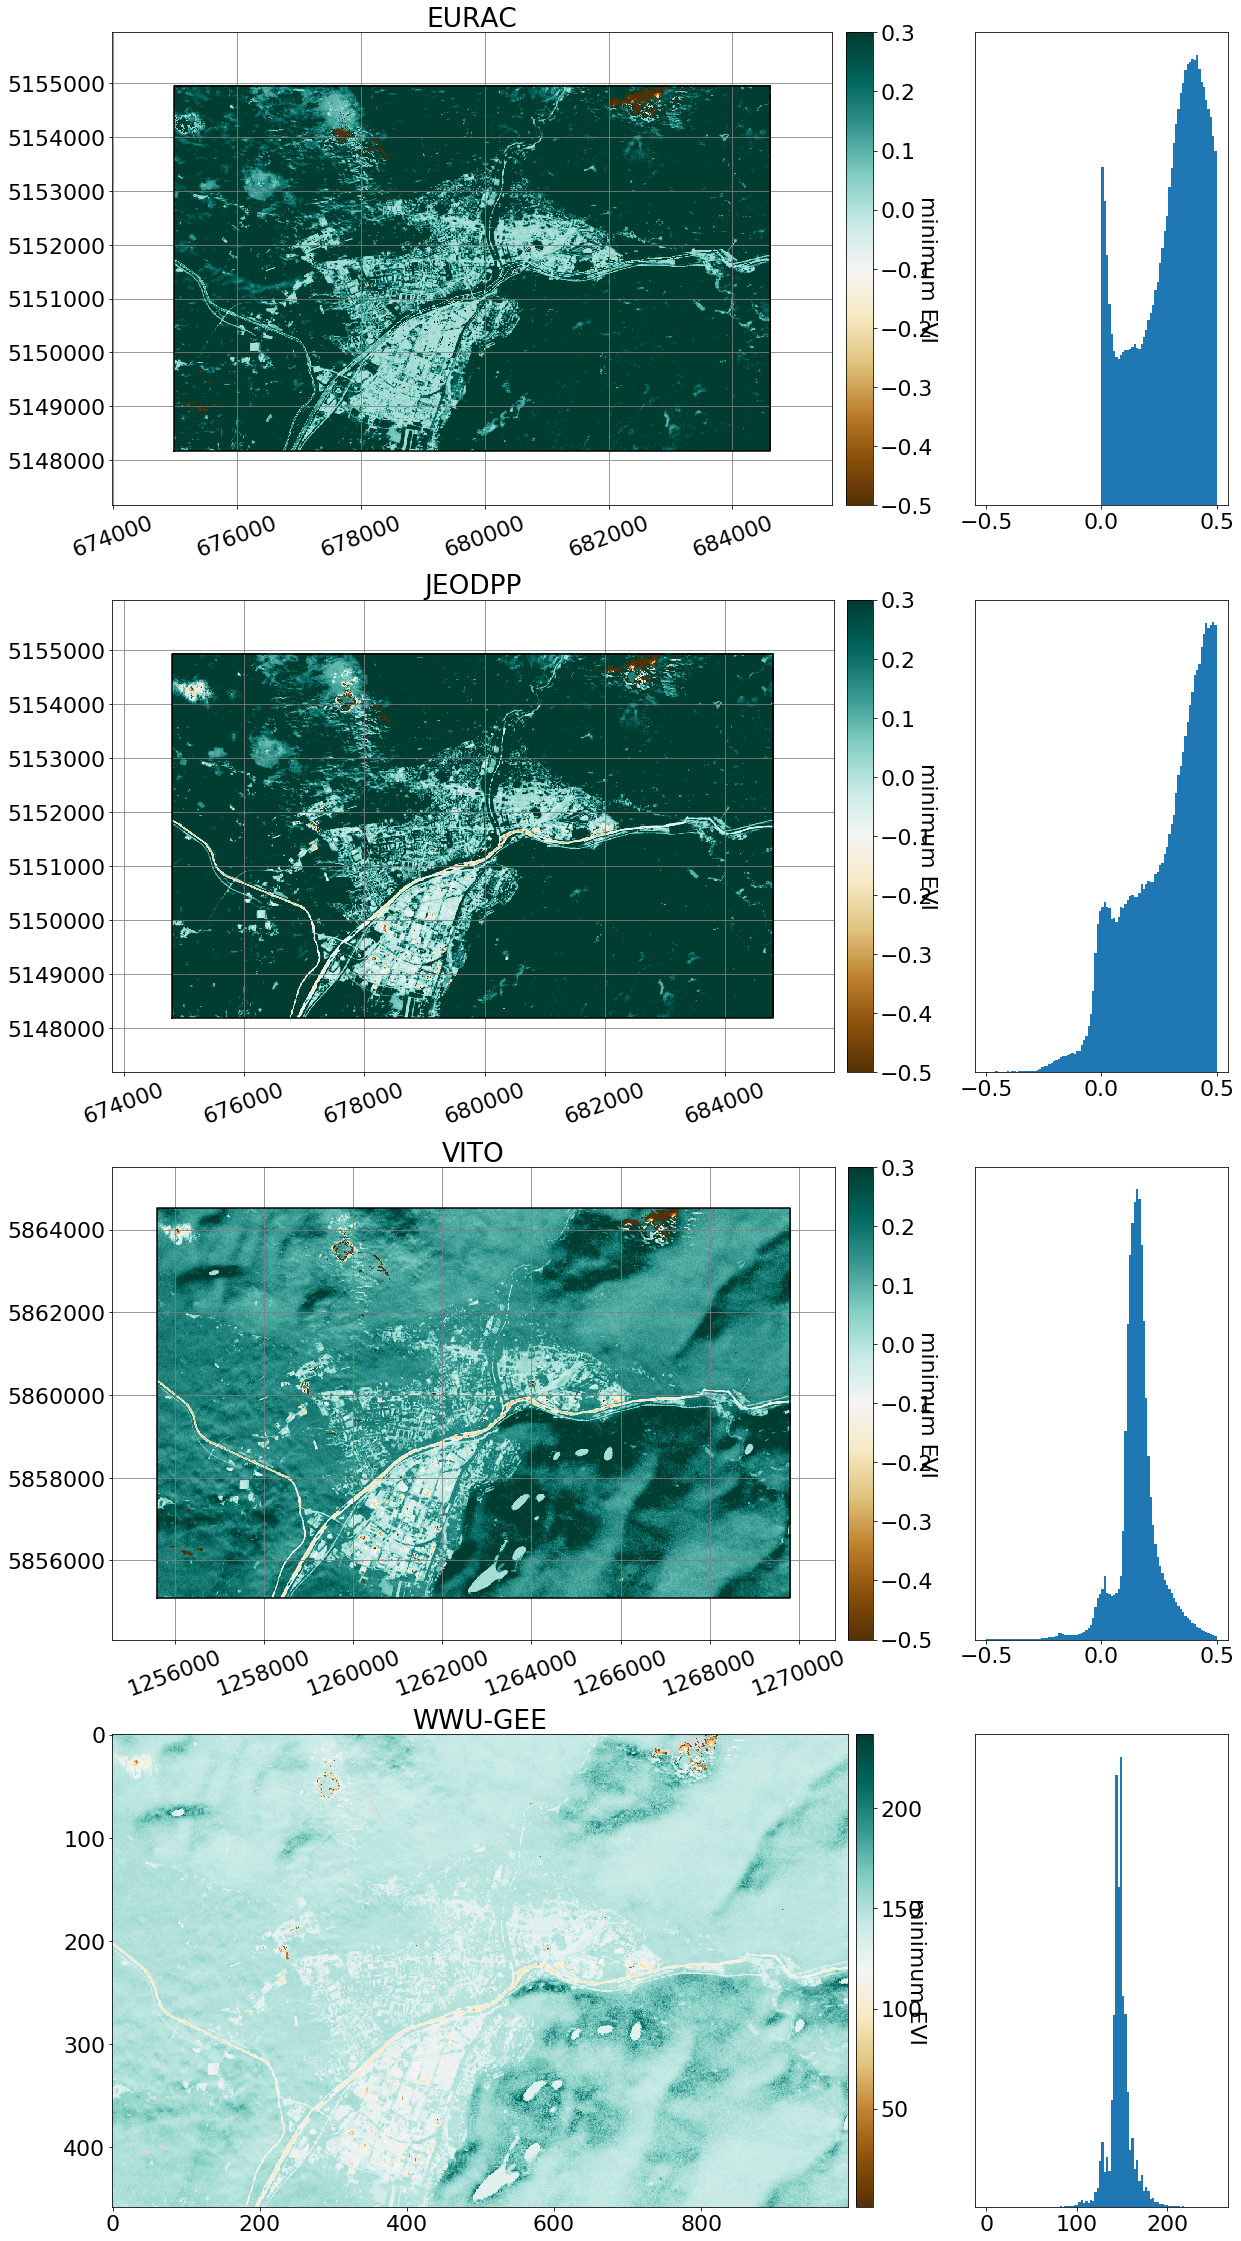

In [24]:
# Make plot

# Create colormap
current_cmap = plt.get_cmap("BrBG")
current_cmap.set_bad(color=[0.85, 0.85, 0.85])

for fig_counter, raster_list in enumerate(rasters_list):
    
    fig = plt.figure(figsize=(20, 10*len(raster_list)))
    gs = gridspec.GridSpec(len(raster_list), 2, width_ratios=[3, 1])
    gs.update(wspace=0.2, hspace=0.2)
    
    for k, item in enumerate(raster_list):
        ## Create axis for subplot ##
        j = k+k
        try:
            ax1 = plt.subplot(gs[j+1])
        except:
            print(j)                    
        ax2 = plt.subplot(gs[j])

        rasters[item]['data'][rasters[item]['data']==0] = np.nan # mostly needed for WWU-GEE

        ## Plot map ##
        ## Plot normalized histogram ##
        if rasters[item]['ds'] and rasters[item]['ds'].GetProjection():
            hist_range = (-0.5, 0.5)
        else:
            hist_range = (0, 255)

        N = rasters[item]['data'].shape[0] * rasters[item]['data'].shape[1]
        tmp_data = rasters[item]['data'].reshape(1, N).flatten()
        tmp_data[tmp_data == -np.inf] = -9999
        tmp_data[np.isnan(tmp_data)] = -9999
        im = ax1.hist(tmp_data, bins=100, range=hist_range, density=True)
        ax1.get_yaxis().set_ticks([]) # no y ticks

        ## Plot map ##
        subplot_title = item.replace('sinergise', 'Sinergise')
        ax2.set_title(subplot_title)
        v_min = -0.5
        v_max = 0.3
        if rasters[item]['ds'] and rasters[item]['ds'].GetProjection():
            if item == 'Sinergise':
                raster_extent, raster_bbox = get_extent(rasters[item]['ds'], geographic=True)
                offset = 0.01 # degrees
            else:
                raster_extent, raster_bbox = get_extent(rasters[item]['ds'])
                offset = 1000 # meters
            im = ax2.imshow(rasters[item]['data'], cmap=current_cmap, vmin=v_min, vmax=v_max, aspect='auto', extent=raster_extent)
            plt.xticks(rotation=20)

            ## Add bounding boxes ##
            ax2.plot(raster_bbox[0], raster_bbox[1], 'k') # raster bbox

            # Add grid lines
            ax2.grid(b=True, which='major', color='gray', linestyle='-')

            # Make axis slightly larger
            ax2.set_xlim(raster_extent[0]-offset, raster_extent[1]+offset)
            ax2.set_ylim(raster_extent[2]-offset, raster_extent[3]+offset)
        else:
            # WWU-GEE is not georeferenced
            im = ax2.imshow(rasters[item]['data'], cmap=current_cmap, aspect='auto')

        im = add_colorbar(im)

        del(ax1, ax2)

    fig.savefig(f'comparison_output/comparison_min-evi_{data_type}_{str(fig_counter)}.png', bbox_inches='tight')